In [10]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from neuralhydrology.evaluation.metrics import calculate_all_metrics, nse
from pathlib import Path

In [11]:
def combinedPlot(lstm_results: Path, lstmPhysics_results: Path, HMS_results: Path, title: str, 
                 test_start_date="01/10/2005", test_end_date="30/09/2009"):
    model1_df = pd.read_csv(lstm_results) #colums: Date, Observed, Predicted
    model2_df = pd.read_csv(lstmPhysics_results) #colums: Date, Observed, Predicted
    model1_df = model1_df.rename(columns={
        'Date': 'date',
        'Observed': 'Observed_Model1',
        'Predicted': 'Predicted_Model1'
    })
    model1_df['date'] = pd.to_datetime(model1_df['date'])

    # Set all negative values in the Predicted_Model1 column to zero
    model1_df.loc[model1_df['Predicted_Model1'] < 0, 'Predicted_Model1'] = 0

    model2_df = model2_df.rename(columns={
        'Date': 'date',
        'Observed': 'Observed_Model2',
        'Predicted': 'Predicted_Model2'
    })
    model2_df['date'] = pd.to_datetime(model2_df['date'])

    # Set all negative values in the Predicted_Model2 column to zero
    model2_df.loc[model2_df['Predicted_Model2'] < 0, 'Predicted_Model2'] = 0
    
    #This just gets the HMS prediceted values from the capella.csv thy gave us
    hms_df = pd.read_csv(HMS_results)
    hms_df = hms_df[3:]
    hms_df.columns = hms_df.columns.str.strip()
    hms_df = hms_df.drop(columns=['Ordinate'])
    hms_df = hms_df.rename(columns={'Date / Time': 'date'})
    hms_df['date'] = pd.to_datetime(hms_df['date'], format='%d-%b-%y')
    hms_df = hms_df.reset_index(drop=True)
    hms_df = hms_df.iloc[:, [0,1]] #Date, HMS predicted
    hms_df = hms_df.rename(columns={hms_df.columns[1]: "HMS_predicted"})
    hms_df["HMS_predicted"] = pd.to_numeric(hms_df["HMS_predicted"], errors="coerce")

    df = model1_df.merge(model2_df, how='right', on='date').merge(hms_df, how='right', on='date')

    # Filter for the test period
    test_start_date = pd.to_datetime("2005-10-01")
    test_end_date = pd.to_datetime("2009-09-30")
    df = df[(df['date'] >= test_start_date) & (df['date'] <= test_end_date)]

    # print nse for each model
    print("The nse for HMS is:", nse(df['Observed_Model1'], df['HMS_predicted']))
    print("The nse for pure LSTM is:", nse(df['Observed_Model1'], df['Predicted_Model1']))
    print("The nse for Physics Informed LSTM is:", nse(df['Observed_Model2'], df['Predicted_Model2']))

    # print("The metrics for HMS is:", calculate_all_metrics(xr.DataArray(df['Observed_Model1'], dims=["time"]), xr.DataArray(df['HMS_predicted'], dims=["time"])))
    # print("The metrics for pure LSTM is:", calculate_all_metrics(df['Observed_Model1'], df['Predicted_Model1']))
    # print("The metrics for Physics Informed LSTM is:", calculate_all_metrics(df['Observed_Model2'], df['Predicted_Model2']))
    # # Convert pandas Series to xarray DataArray with a datetime coordinate
    # obs_da = xr.DataArray(df['Observed_Model1'].values, dims=["date"], coords={"date": df['date']})
    # sim_da_hms = xr.DataArray(df['HMS_predicted'].values, dims=["date"], coords={"date": df['date']})
    # sim_da_lstm = xr.DataArray(df['Predicted_Model1'].values, dims=["date"], coords={"date": df['date']})
    # sim_da_physics = xr.DataArray(df['Predicted_Model2'].values, dims=["date"], coords={"date": df['date']})

    # # Collect metrics into a dictionary
    # metrics = {
    #     "HMS": calculate_all_metrics(obs_da, sim_da_hms),
    #     "LSTM": calculate_all_metrics(obs_da, sim_da_lstm),
    #     "Physics_Informed_LSTM": calculate_all_metrics(obs_da, sim_da_physics),
    # }

    # metrics_df = pd.DataFrame(metrics)
    # output_csv_path = "calpella_metrics.csv"
    # metrics_df.to_csv(output_csv_path)

    # # Pass xarray DataArrays with coordinates to calculate_all_metrics
    # print("The metrics for HMS is:", calculate_all_metrics(obs_da, sim_da_hms))
    # print("The metrics for pure LSTM is:", calculate_all_metrics(obs_da, sim_da_lstm))
    # print("The metrics for Physics Informed LSTM is:", calculate_all_metrics(obs_da, sim_da_physics))

    # Plot all columns against the "date_col" (x-axis)
    plt.figure(figsize=(30, 10))
    
    plt.plot(df["date"], df["Observed_Model1"], label='Observed', linewidth=2) #color="blue",
    plt.plot(df["date"], df["Predicted_Model1"], label='LSTM Prediction', linewidth=2, alpha=0.8) #color="purple",
    plt.plot(df["date"], df["Predicted_Model2"], label='Physics Informed LSTM Prediction', linewidth=2, alpha=0.7) #color="orange",
    plt.plot(df["date"], df["HMS_predicted"], label='HMS Prediction',  linewidth=2, alpha=0.7) #color="lightblue",

    # Customize the plot
    plt.tick_params(axis='x', labelsize=15)  # For x-axis tick labels
    plt.tick_params(axis='y', labelsize=15) 
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Inflow (cubic feet per second)", fontsize=20)
    plt.title(title, fontsize=30)
    plt.legend(fontsize=25, loc="upper right")
    plt.grid(True, alpha=0.4)

    plt.xlim(test_start_date, test_end_date)

    #plt.gcf.autofmt_xdate()
    plt.tight_layout()
    plt.show()

The nse for HMS is: 0.69918539545278
The nse for pure LSTM is: 0.7930236178530892
The nse for Physics Informed LSTM is: 0.8217133099486427


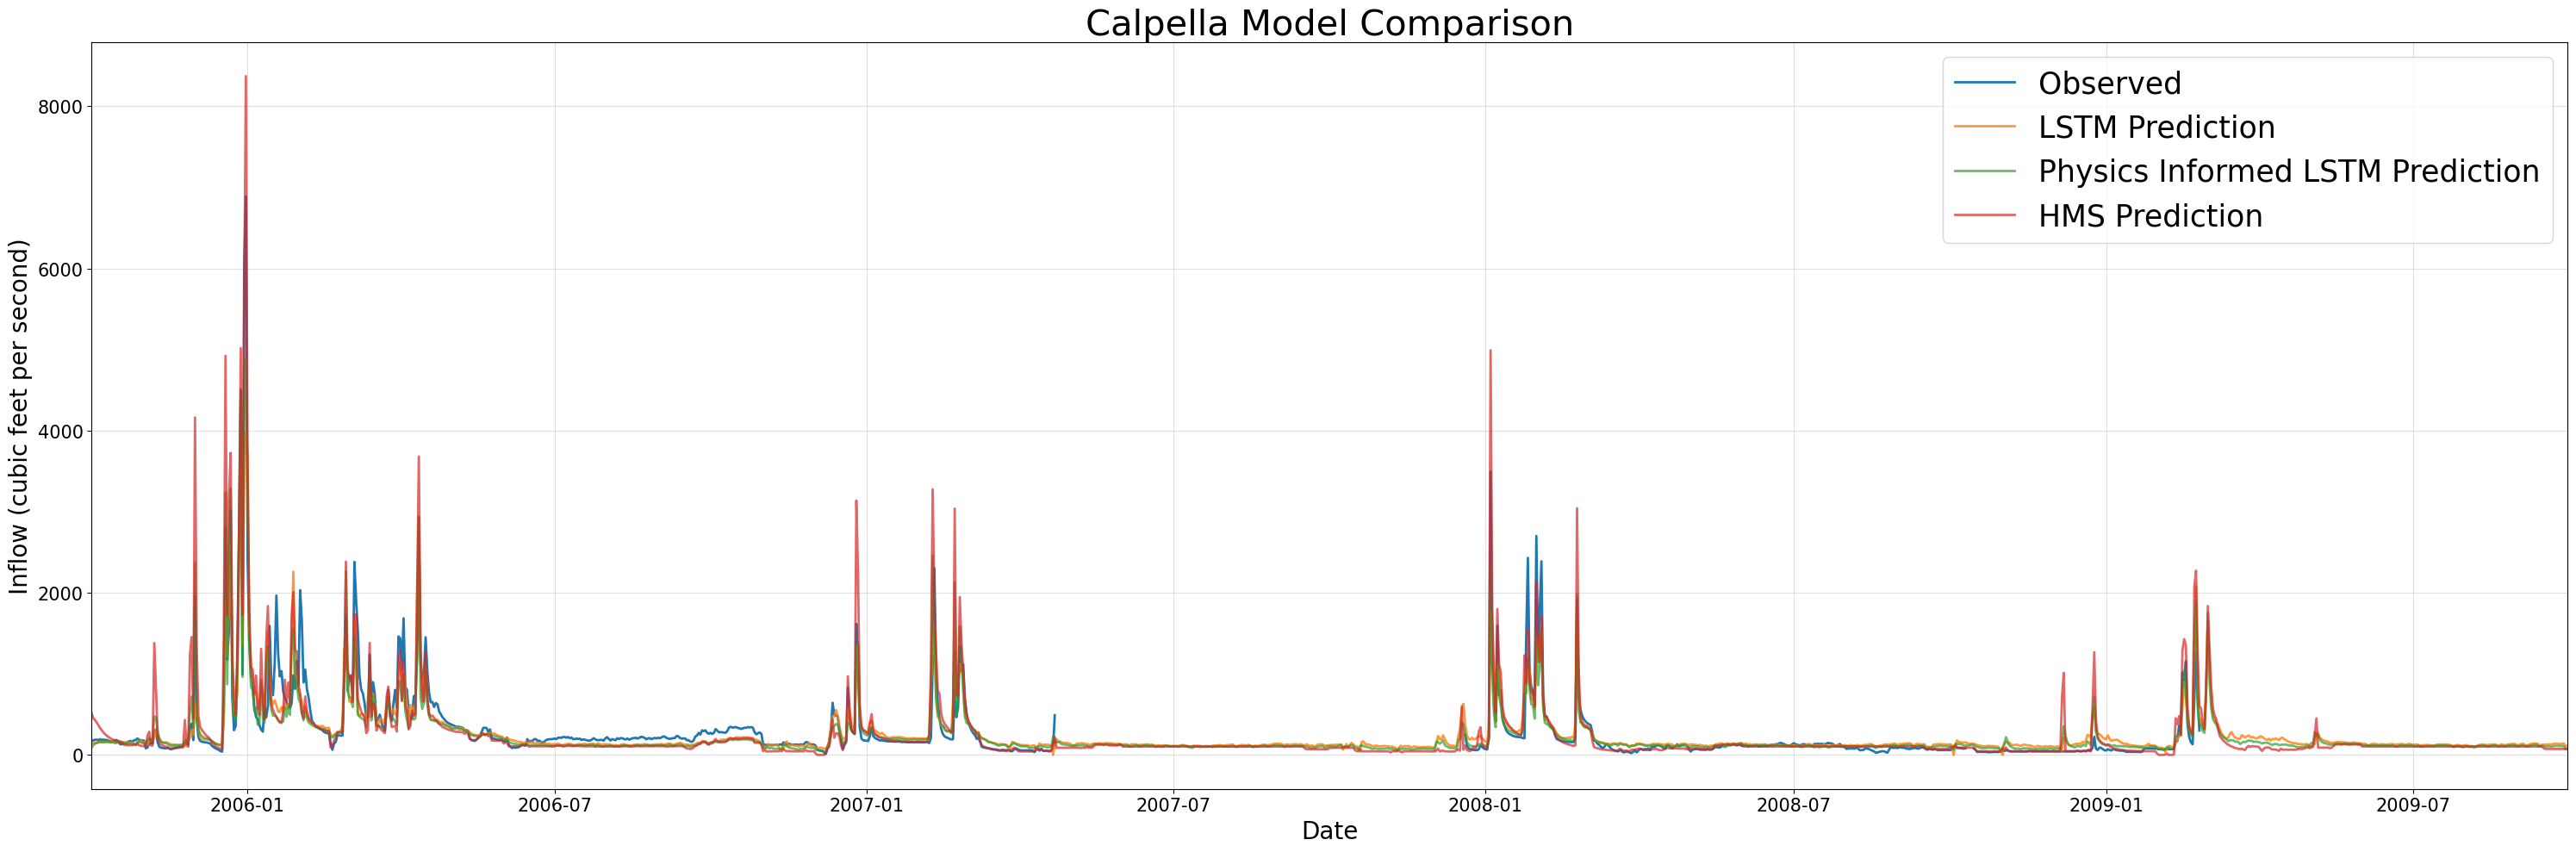

In [12]:
lstm_result_path = Path('/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_0212_152517/results_output.csv')
physics_informed_result_path = Path('/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/calpella_all/runs/testing_run_0212_154906/results_output.csv')
path_to_physics_data = Path("/Users/mia/research/calpella_data_folder/new_calpella.csv")
combinedPlot(lstm_results=lstm_result_path, lstmPhysics_results= physics_informed_result_path, HMS_results=path_to_physics_data, title='Calpella Model Comparison')